<a href="https://colab.research.google.com/github/cc-ca/commentaires_toxiques/blob/Rodolphe/Test_Classification_commentaires_toxiques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importation des packages

In [ ]:
!pip install tokenizers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 13.6 MB/s eta 0:00:00


In [ ]:
!pip install scikit-multilearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 KB 5.9 MB/s eta 0:00:00


In [ ]:
!pip install -q gensim

In [ ]:
!pip install tfa-nightly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 32.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

import nltk, string
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
import re
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.model_selection import train_test_split  
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import tokenizers
from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve, auc

from skmultilearn.problem_transform import BinaryRelevance
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import roc_auc_score, log_loss, hamming_loss, accuracy_score

import gensim
import gensim.downloader as api

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Dense, Bidirectional, Embedding, LSTM, BatchNormalization, Dropout

import tensorflow_addons as tfa



# Importation des données

Ajoutez un raccourci de ce dossier à votre google drive :

https://drive.google.com/drive/folders/1mx-CAzT10YKrmxHfYDP_1Oef7PVGUr7s?usp=sharing

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/data_classification_commentaires_toxiques/train.csv')
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# Etude du jeu de données

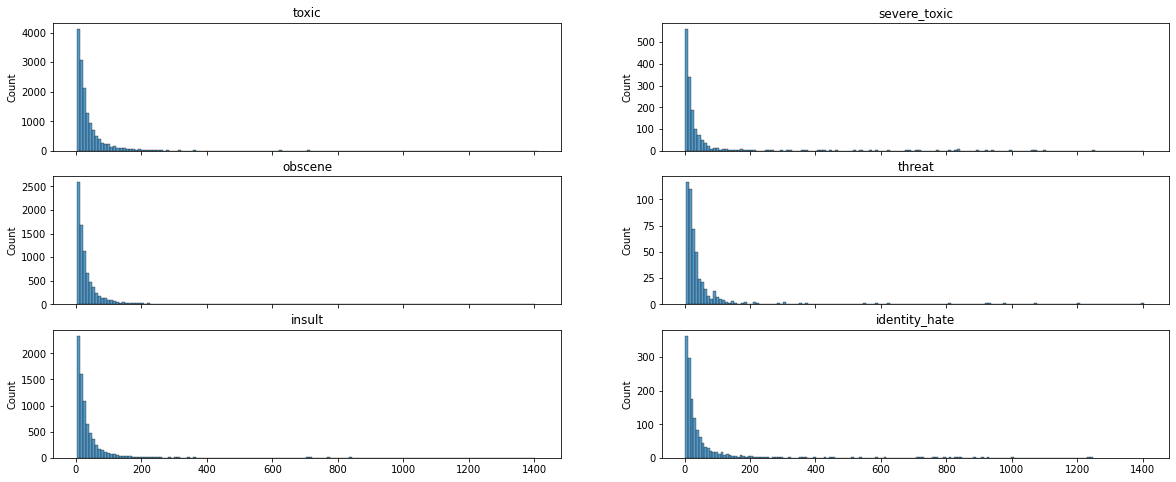

In [ ]:
labels = ['toxic','severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
fig, ax = plt.subplots(3, 2, figsize=(20,8), sharex=True)
axes =ax.ravel()
for i in range(6):
  comments = data.loc[data[labels[i]] == 1, :]
  comment_len = [len(comment.split()) for comment in comments["comment_text"]]
  sns.histplot(comment_len, ax=axes[i], bins = 150);
  axes[i].title.set_text(labels[i]);

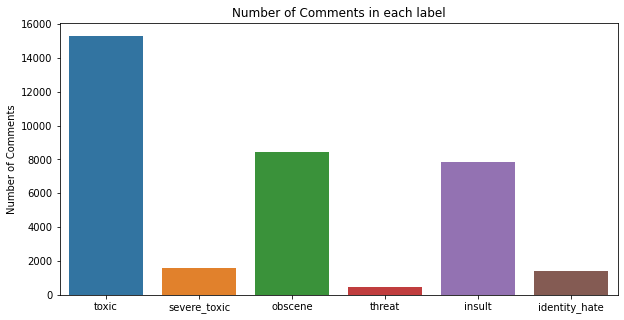

In [ ]:
# Number of tweets in each labels
labels_count = data[labels].sum()
plt.figure(figsize = (10,5))
sns.barplot(x = labels_count.index,y = labels_count.values);
plt.title("Number of Comments in each label");
plt.ylabel("Number of Comments");

In [ ]:
multilabel_count = data[labels].sum(axis = 1).value_counts()
multilabel_count

0    143346
1      6360
3      4209
2      3480
4      1760
5       385
6        31
dtype: int64

# Préparation des données

In [ ]:
#regarder le code de C pour train et test
data_train = data

data_test = pd.read_csv('/content/drive/MyDrive/data_classification_commentaires_toxiques/test.csv')
data_test_labels = pd.read_csv('/content/drive/MyDrive/data_classification_commentaires_toxiques/test_labels.csv')

data_test = pd.merge(data_test, data_test_labels, on = ['id'])

In [ ]:
def clean(tweet): 
            
    # Contractions
    tweet = re.sub(r"he's", "he is", tweet)
    tweet = re.sub(r"there's", "there is", tweet)
    tweet = re.sub(r"We're", "We are", tweet)
    tweet = re.sub(r"That's", "That is", tweet)
    tweet = re.sub(r"won't", "will not", tweet)
    tweet = re.sub(r"they're", "they are", tweet)
    tweet = re.sub(r"Can't", "Cannot", tweet)
    tweet = re.sub(r"wasn't", "was not", tweet)
    tweet = re.sub(r"don\x89Ûªt", "do not", tweet)
    tweet = re.sub(r"aren't", "are not", tweet)
    tweet = re.sub(r"isn't", "is not", tweet)
    tweet = re.sub(r"What's", "What is", tweet)
    tweet = re.sub(r"haven't", "have not", tweet)
    tweet = re.sub(r"hasn't", "has not", tweet)
    tweet = re.sub(r"There's", "There is", tweet)
    tweet = re.sub(r"He's", "He is", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"You're", "You are", tweet)
    tweet = re.sub(r"I'M", "I am", tweet)
    tweet = re.sub(r"shouldn't", "should not", tweet)
    tweet = re.sub(r"wouldn't", "would not", tweet)
    tweet = re.sub(r"i'm", "I am", tweet)
    tweet = re.sub(r"I\x89Ûªm", "I am", tweet)
    tweet = re.sub(r"I'm", "I am", tweet)
    tweet = re.sub(r"Isn't", "is not", tweet)
    tweet = re.sub(r"Here's", "Here is", tweet)
    tweet = re.sub(r"you've", "you have", tweet)
    tweet = re.sub(r"you\x89Ûªve", "you have", tweet)
    tweet = re.sub(r"we're", "we are", tweet)
    tweet = re.sub(r"what's", "what is", tweet)
    tweet = re.sub(r"couldn't", "could not", tweet)
    tweet = re.sub(r"we've", "we have", tweet)
    tweet = re.sub(r"it\x89Ûªs", "it is", tweet)
    tweet = re.sub(r"doesn\x89Ûªt", "does not", tweet)
    tweet = re.sub(r"It\x89Ûªs", "It is", tweet)
    tweet = re.sub(r"Here\x89Ûªs", "Here is", tweet)
    tweet = re.sub(r"who's", "who is", tweet)
    tweet = re.sub(r"I\x89Ûªve", "I have", tweet)
    tweet = re.sub(r"y'all", "you all", tweet)
    tweet = re.sub(r"can\x89Ûªt", "cannot", tweet)
    tweet = re.sub(r"would've", "would have", tweet)
    tweet = re.sub(r"it'll", "it will", tweet)
    tweet = re.sub(r"we'll", "we will", tweet)
    tweet = re.sub(r"wouldn\x89Ûªt", "would not", tweet)
    tweet = re.sub(r"We've", "We have", tweet)
    tweet = re.sub(r"he'll", "he will", tweet)
    tweet = re.sub(r"Y'all", "You all", tweet)
    tweet = re.sub(r"Weren't", "Were not", tweet)
    tweet = re.sub(r"Didn't", "Did not", tweet)
    tweet = re.sub(r"they'll", "they will", tweet)
    tweet = re.sub(r"they'd", "they would", tweet)
    tweet = re.sub(r"DON'T", "DO NOT", tweet)
    tweet = re.sub(r"That\x89Ûªs", "That is", tweet)
    tweet = re.sub(r"they've", "they have", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"should've", "should have", tweet)
    tweet = re.sub(r"You\x89Ûªre", "You are", tweet)
    tweet = re.sub(r"where's", "where is", tweet)
    tweet = re.sub(r"Don\x89Ûªt", "Do not", tweet)
    tweet = re.sub(r"we'd", "we would", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"weren't", "were not", tweet)
    tweet = re.sub(r"They're", "They are", tweet)
    tweet = re.sub(r"Can\x89Ûªt", "Cannot", tweet)
    tweet = re.sub(r"you\x89Ûªll", "you will", tweet)
    tweet = re.sub(r"I\x89Ûªd", "I would", tweet)
    tweet = re.sub(r"let's", "let us", tweet)
    tweet = re.sub(r"it's", "it is", tweet)
    tweet = re.sub(r"can't", "cannot", tweet)
    tweet = re.sub(r"don't", "do not", tweet)
    tweet = re.sub(r"you're", "you are", tweet)
    tweet = re.sub(r"i've", "I have", tweet)
    tweet = re.sub(r"that's", "that is", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"doesn't", "does not", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"didn't", "did not", tweet)
    tweet = re.sub(r"ain't", "am not", tweet)
    tweet = re.sub(r"you'll", "you will", tweet)
    tweet = re.sub(r"I've", "I have", tweet)
    tweet = re.sub(r"Don't", "do not", tweet)
    tweet = re.sub(r"I'll", "I will", tweet)
    tweet = re.sub(r"I'd", "I would", tweet)
    tweet = re.sub(r"Let's", "Let us", tweet)
    tweet = re.sub(r"you'd", "You would", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"Ain't", "am not", tweet)
    tweet = re.sub(r"Haven't", "Have not", tweet)
    tweet = re.sub(r"Could've", "Could have", tweet)
    tweet = re.sub(r"youve", "you have", tweet)  
    tweet = re.sub(r"donå«t", "do not", tweet)  
    
    tweet = re.sub(r"some1", "someone", tweet)
    tweet = re.sub(r"yrs", "years", tweet)
    tweet = re.sub(r"hrs", "hours", tweet)
    tweet = re.sub(r"2morow|2moro", "tomorrow", tweet)
    tweet = re.sub(r"2day", "today", tweet)
    tweet = re.sub(r"4got|4gotten", "forget", tweet)
    tweet = re.sub(r"b-day|bday", "b-day", tweet)
    tweet = re.sub(r"mother's", "mother", tweet)
    tweet = re.sub(r"mom's", "mom", tweet)
    tweet = re.sub(r"dad's", "dad", tweet)
    tweet = re.sub(r"hahah|hahaha|hahahaha", "haha", tweet)
    tweet = re.sub(r"lmao|lolz|rofl", "lol", tweet)
    tweet = re.sub(r"thanx|thnx", "thanks", tweet)
    tweet = re.sub(r"goood", "good", tweet)
    tweet = re.sub(r"some1", "someone", tweet)
    tweet = re.sub(r"some1", "someone", tweet)
    # Character entity references
    tweet = re.sub(r"&gt;", ">", tweet)
    tweet = re.sub(r"&lt;", "<", tweet)
    tweet = re.sub(r"&amp;", "&", tweet)
    # Typos, slang and informal abbreviations
    tweet = re.sub(r"w/e", "whatever", tweet)
    tweet = re.sub(r"w/", "with", tweet)
    tweet = re.sub(r"<3", "love", tweet)
    # Urls
    tweet = re.sub(r"http\S+", "", tweet)
    # Numbers
    tweet = re.sub(r'[0-9]', '', tweet)
    # Eliminating the mentions
    tweet = re.sub("(@[A-Za-z0-9_]+)","", tweet)
    # Remove punctuation and special chars (keep '!')
    for p in string.punctuation.replace('!', ''):
        tweet = tweet.replace(p, '')
        
    # ... and ..
    tweet = tweet.replace('...', ' ... ')
    if '...' not in tweet:
        tweet = tweet.replace('..', ' ... ')
        
    # Tokenize
    tweet_words = tokenizer.tokenize(tweet)
    
    # Eliminating the word if its length is less than 3
    tweet = [w for w in tweet_words if len(w)>2]
    
    # remove stopwords
    tweet = [w.lower() for w in tweet if not w in stop_words]  
    
    corpus.append(tweet)
    
    # join back
    tweet = ' '.join(tweet)
        
        
    return tweet

In [ ]:
variable_name = ""
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", 
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
     "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

def convert_abbrev_in_text(tweet):
    t=[]
    words=tweet.split()
    t = [abbreviations[w.lower()] if w.lower() in abbreviations.keys() else w for w in words]
    return ' '.join(t) 

In [ ]:
tokenizer = TweetTokenizer(strip_handles=True)
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')
corpus = []

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def prepare_string(tweet):
  tweet = clean(tweet)
  tweet = convert_abbrev_in_text(tweet)
  return tweet

In [ ]:
%%time
# Apply prepare_string to all rows in 'tweets' column
data_train['comment_text'] = data_train['comment_text'].apply(lambda s : prepare_string(s))

# Drop empty values from dataframe
data_train['comment_text'].replace('', np.nan, inplace=True)
data_train.dropna(subset=['comment_text'], inplace=True)
data_train.drop(columns=["id"])

CPU times: user 1min 40s, sys: 424 ms, total: 1min 40s
Wall time: 1min 44s


,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,explanation why edits made username hardcore m...,0,0,0,0,0,0
1,daww matches background colour seemingly stuck...,0,0,0,0,0,0
2,hey man really trying edit war guy constantly ...,0,0,0,0,0,0
3,more cannot make real suggestions improvement ...,0,0,0,0,0,0
4,you sir hero any chance remember page,0,0,0,0,0,0
...,...,...,...,...,...,...,...
159566,and second time asking view completely contrad...,0,0,0,0,0,0
159567,you ashamed that horrible thing put talk page,0,0,0,0,0,0
159568,spitzer umm theres actual article prostitution...,0,0,0,0,0,0
159569,and looks like actually put speedy first versi...,0,0,0,0,0,0


In [ ]:
%%time
nb = data_test['toxic'].count()
print(nb,'commentaires')
# Apply prepare_string to all rows in 'tweets' column
data_test["comment_text"] = data_test["comment_text"].apply(lambda s : prepare_string(s))

# Drop empty values from dataframe
data_test.replace('', np.nan, inplace=True)
data_test.dropna(subset=['comment_text'], inplace=True)
#on supp tout les comm pas toxiques :
data_test.drop(data_test[data_test['toxic']== -1].index, inplace = True)
data_test.drop(columns=["id"])

153164 commentaires
CPU times: user 1min 26s, sys: 379 ms, total: 1min 27s
Wall time: 1min 27s


,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
5,thank understanding think highly would revert ...,0,0,0,0,0,0
7,dear god site horrible,0,0,0,0,0,0
11,somebody invariably try add religion really yo...,0,0,0,0,0,0
13,says right type the type institution needed ca...,0,0,0,0,0,0
14,before adding new product list make sure relev...,0,0,0,0,0,0
...,...,...,...,...,...,...,...
153150,jerome see never got around surprised looked e...,0,0,0,0,0,0
153151,lucky bastard heh famous kida envy congrats,0,0,0,0,0,0
153154,shame you want speak gays romanians,0,0,0,0,0,0
153155,mel gibson nazi bitch who makes shitty movies ...,1,0,1,0,1,0


In [ ]:
labels = ['toxic','severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

x_train = data_train['comment_text']
y_train = data_train.drop(columns=['id', 'comment_text'])

x_test = data_test["comment_text"]
y_test = data_test.drop(columns=["comment_text", "id"])


In [ ]:
y_test

,toxic,severe_toxic,obscene,threat,insult,identity_hate
5,0,0,0,0,0,0
7,0,0,0,0,0,0
11,0,0,0,0,0,0
13,0,0,0,0,0,0
14,0,0,0,0,0,0
...,...,...,...,...,...,...
153150,0,0,0,0,0,0
153151,0,0,0,0,0,0
153154,0,0,0,0,0,0
153155,1,0,1,0,1,0


In [ ]:
x_test

5         thank understanding think highly would revert ...
7                                    dear god site horrible
11        somebody invariably try add religion really yo...
13        says right type the type institution needed ca...
14        before adding new product list make sure relev...
                                ...                        
153150    jerome see never got around surprised looked e...
153151          lucky bastard heh famous kida envy congrats
153154                  shame you want speak gays romanians
153155    mel gibson nazi bitch who makes shitty movies ...
153156    unicorn lair discovery supposedly unicorn lair...
Name: comment_text, Length: 63873, dtype: object

In [ ]:
tfidf_vec = TfidfVectorizer(ngram_range=(1,2), 
                            min_df=2, 
                            max_features=1000)
tfidf_vec.fit(x_train)

train_tfidf = tfidf_vec.transform(x_train)
test_tfidf = tfidf_vec.transform(x_test)

In [ ]:
# evaluation function

    
    #à modif pour avoir le f1score

In [ ]:
model = api.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
word_vectors = model.wv 

def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, tokens, generate_missing=False):
    embeddings = tokens.apply(lambda x: get_average_word2vec(x, vectors, 
                                                            generate_missing=generate_missing))
    return list(embeddings)

<ipython-input-24-c339f758c206>:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  word_vectors = model.wv


In [ ]:
train_we_tokens = x_train
test_we_tokens = x_test

train_embeddings = get_word2vec_embeddings(vectors=word_vectors, tokens=train_we_tokens)
test_embeddings = get_word2vec_embeddings(vectors=word_vectors, tokens=test_we_tokens)

In [ ]:
train_embeddings_matrix = np.array(train_embeddings)
test_embeddings_matrix = np.array(test_embeddings)

print(train_embeddings_matrix.shape,  test_embeddings_matrix.shape)

(159513, 300) (63873, 300)


In [ ]:
VOCAB_SIZE = 10000
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='')

tokenizer.fit_on_texts(x_train.values)

word_index = tokenizer.word_index
print(f'Number of unique words found: {len(word_index)}')

Number of unique words found: 217807


In [ ]:
train_tokens = tokenizer.texts_to_sequences(x_train.values)
test_tokens = tokenizer.texts_to_sequences(x_test.values)

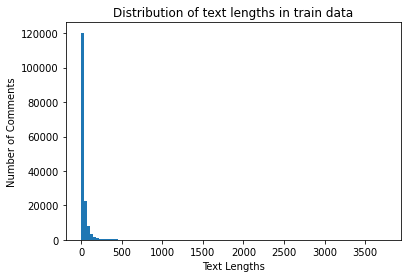

In [ ]:
text_lengths = [len(seq) for seq in train_tokens]
plt.hist(text_lengths, bins=100);
plt.title("Distribution of text lengths in train data");
plt.xlabel('Text Lengths');
plt.ylabel("Number of Comments");

In [ ]:
PAD_LENGTH = 200
train_padded = pad_sequences(train_tokens, maxlen = PAD_LENGTH,padding='post',truncating='post')
test_padded = pad_sequences(test_tokens, maxlen = PAD_LENGTH,padding='post',truncating='post')

In [ ]:
model = Sequential()
model.add(Input(shape=(None,)))

# Embedding layer
model.add(Embedding(input_dim=VOCAB_SIZE+1, output_dim=300, 
                    input_length=PAD_LENGTH, mask_zero=True))

# LSTM layer
model.add(LSTM(units= 50, dropout=0.4, return_sequences=False))
# Dense layer
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(6, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         3000300   
                                                                 
 lstm (LSTM)                 (None, 50)                70200     
                                                                 
 dense (Dense)               (None, 512)               26112     
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 3078      
                                                        

In [ ]:
f1 = tfa.metrics.F1Score(num_classes=5,average=None,threshold= 0.5)

model.compile(tf.keras.optimizers.Adam(learning_rate=0.02),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tfa.metrics.F1Score(num_classes=6, threshold=0.5)])

In [ ]:
callbacks = [tf.keras.callbacks.ModelCheckpoint('best_lstm_model', save_best_only=True),
             tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.2),
              tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)]

In [ ]:
lstm_history = model.fit(train_padded, y_train,
                         validation_data = (test_padded, y_test),
                         batch_size=32,
                         epochs = 10, callbacks = callbacks)

Epoch 1/10


/usr/local/lib/python3.8/dist-packages/keras/backend.py:5676: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


4985/4985 [==============================] - ETA: 0s - loss: 0.0993 - f1_score: 0.3014

/usr/local/lib/python3.8/dist-packages/keras/backend.py:5676: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


4985/4985 [==============================] - 202s 38ms/step - loss: 0.0993 - f1_score: 0.3014 - val_loss: 0.0941 - val_f1_score: 0.3134 - lr: 0.0200
Epoch 2/10
4985/4985 [==============================] - 98s 20ms/step - loss: 0.1001 - f1_score: 0.2941 - val_loss: 0.0963 - val_f1_score: 0.2558 - lr: 0.0200
Epoch 3/10
4985/4985 [==============================] - 89s 18ms/step - loss: 0.0989 - f1_score: 0.3019 - val_loss: 0.0973 - val_f1_score: 0.2286 - lr: 0.0200
Epoch 4/10
4984/4985 [============================>.] - ETA: 0s - loss: 0.0853 - f1_score: 0.3104

4985/4985 [==============================] - 100s 20ms/step - loss: 0.0853 - f1_score: 0.3104 - val_loss: 0.0931 - val_f1_score: 0.2922 - lr: 0.0040
Epoch 5/10
4985/4985 [==============================] - ETA: 0s - loss: 0.0817 - f1_score: 0.3275

4985/4985 [==============================] - 103s 21ms/step - loss: 0.0817 - f1_score: 0.3275 - val_loss: 0.0899 - val_f1_score: 0.3436 - lr: 0.0040
Epoch 6/10
4983/4985 [============================>.] - ETA: 0s - loss: 0.0789 - f1_score: 0.3355

4985/4985 [==============================] - 99s 20ms/step - loss: 0.0789 - f1_score: 0.3356 - val_loss: 0.0876 - val_f1_score: 0.3305 - lr: 0.0040
Epoch 7/10
4985/4985 [==============================] - 89s 18ms/step - loss: 0.0768 - f1_score: 0.3497 - val_loss: 0.0914 - val_f1_score: 0.3609 - lr: 0.0040
Epoch 8/10
4985/4985 [==============================] - 86s 17ms/step - loss: 0.0747 - f1_score: 0.3520 - val_loss: 0.0926 - val_f1_score: 0.3062 - lr: 0.0040
Epoch 9/10
4985/4985 [==============================] - ETA: 0s - loss: 0.0720 - f1_score: 0.3572

4985/4985 [==============================] - 99s 20ms/step - loss: 0.0720 - f1_score: 0.3572 - val_loss: 0.0833 - val_f1_score: 0.3382 - lr: 8.0000e-04
Epoch 10/10
4985/4985 [==============================] - 87s 17ms/step - loss: 0.0707 - f1_score: 0.3543 - val_loss: 0.0892 - val_f1_score: 0.3391 - lr: 8.0000e-04


# Entraînement du modèle baseline

In [ ]:
# Your Code

# Itération de la modélisation 

In [ ]:
# Your Code 